In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,UUID,Major,Minor,RSSI,X,Y,Timestamp,SessId
0,b9407f30f5f8466eaff925556b57fe6d,1,9617,-87,3.337088,1.324216,1493749680685,12
1,b9407f30f5f8466eaff925556b57fe6d,1,9618,-70,3.335436,1.324163,1493749680687,12
2,b9407f30f5f8466eaff925556b57fe6d,1,9619,-85,3.320566,1.323686,1493749680705,12
3,b9407f30f5f8466eaff925556b57fe6d,1,9616,-80,3.318914,1.323633,1493749680707,12
4,b9407f30f5f8466eaff925556b57fe6d,1,9609,-81,3.265217,1.321913,1493749680772,12


In [4]:
df = df[df.UUID == 'b9407f30f5f8466eaff925556b57fe6d']

In [5]:
sess = df[df.SessId == 1]

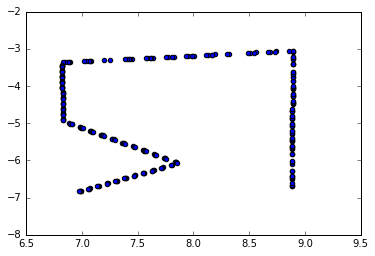

In [6]:
plt.scatter(sess.X, -sess.Y)

In [7]:
def plot_rssi_data(df, figsize=(15, 10), smooth_func=lambda x: x):
    min_time = df.Timestamp.min()
    unique_minors = df.Minor.unique()
    fig = plt.figure(figsize=figsize)
    for i, minor in enumerate(unique_minors):
        bd = smooth_func(df[df.Minor == minor])
        ax = plt.subplot(int(np.ceil(len(unique_minors) / 3)), 3, 1 + i)
        ax.set_title(str(minor))
        plt.plot(bd.Timestamp-min_time, bd.RSSI)

In [8]:
def plot_rssi_map(df, figsize=(15, 10), smooth_func=lambda x: x):
    min_time = df.Timestamp.min()
    unique_minors = df.Minor.unique()
    fig = plt.figure(figsize=figsize)
    for i, minor in enumerate(unique_minors):
        bd = smooth_func(df[df.Minor == minor])
        ax = plt.subplot(int(np.ceil(len(unique_minors) / 3)), 3, 1 + i)
        ax.set_title(str(minor))
        plt.scatter(bd.X, -bd.Y, c=-bd.RSSI, cmap='Greys')


In [9]:
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.signal import medfilt

In [10]:
def rssi_lowess_smooth(df):
    smoothed = lowess(df.RSSI, df.Timestamp)
    new_df = df.copy()
    new_df.RSSI = smoothed[:, 1]
    new_df.Timestamp = smoothed[:, 0]
    return new_df

In [11]:
def create_rssi_median_filter(kernel=9):
    def median_filter(df):
        smoothed = medfilt(df.RSSI, kernel)
        new_df = df.copy()
        new_df.RSSI = smoothed
        return new_df
    return median_filter

In [12]:
def plot_session(df):
    plt.title("Route")
    plt.scatter(df.X, -df.Y)
    plot_rssi_data(sess, smooth_func=rssi_lowess_smooth)
    plot_rssi_map(sess, smooth_func=rssi_lowess_smooth)

In [13]:
def filter_session(sess_df):
    result = pd.DataFrame()
    for minor in sess_df.Minor.unique():
        result = result.append(rssi_lowess_smooth(sess_df[sess_df.Minor == minor]))
    return result

In [14]:
def filter_rssi_df(df):
    result = pd.DataFrame()
    for sess_id in df.SessId.unique():
        result = result.append(filter_session(df[df.SessId == sess_id]))
    return result

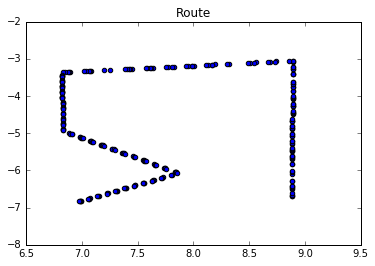

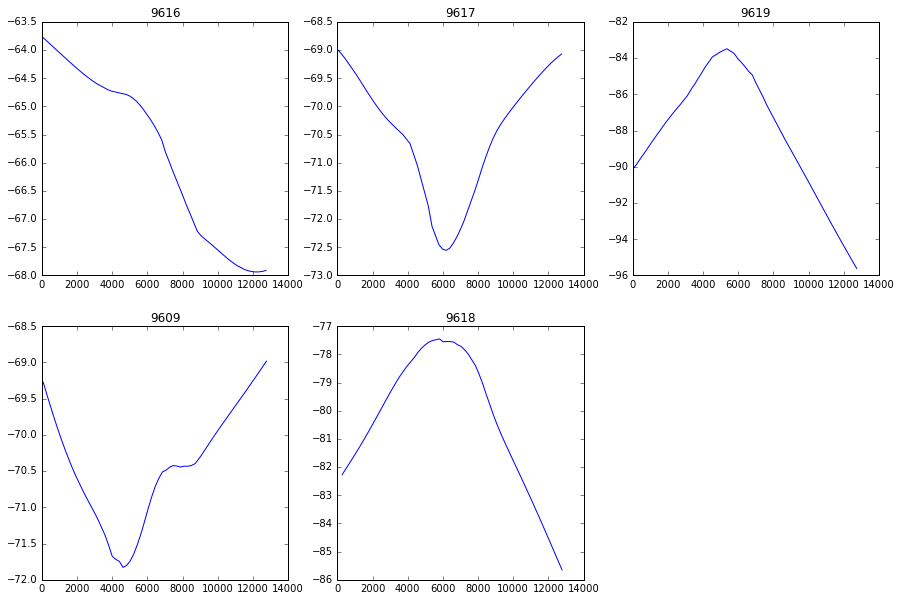

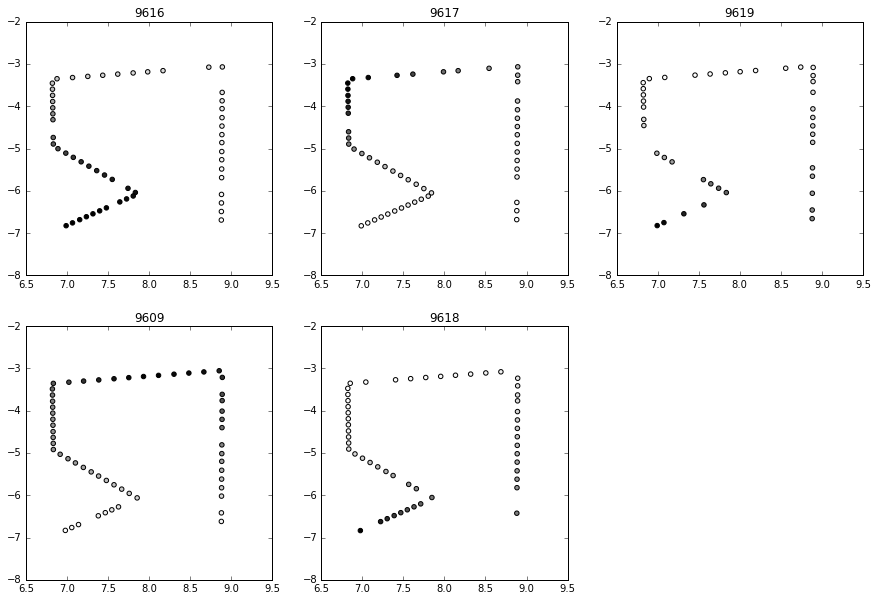

In [15]:
plot_session(sess)

In [16]:
filtered_df = filter_rssi_df(df)

In [17]:
filtered_df.head()

,UUID,Major,Minor,RSSI,X,Y,Timestamp,SessId
0,b9407f30f5f8466eaff925556b57fe6d,1,9617,-84.836897,3.337088,1.324216,1.493750e+12,12
5,b9407f30f5f8466eaff925556b57fe6d,1,9617,-84.651588,3.171042,1.318895,1.493750e+12,12
9,b9407f30f5f8466eaff925556b57fe6d,1,9617,-84.460786,3.007474,1.313654,1.493750e+12,12
13,b9407f30f5f8466eaff925556b57fe6d,1,9617,-84.249968,2.835644,1.308147,1.493750e+12,12
18,b9407f30f5f8466eaff925556b57fe6d,1,9617,-84.028896,2.665468,1.302694,1.493750e+12,12


In [18]:
route_1_rssi = pd.read_csv('long_route_1_rssi.txt')
route_1_pos = pd.read_csv('long_route_1_position.txt')

In [19]:
route_1_rssi = route_1_rssi[route_1_rssi.UUID == 'b9407f30f5f8466eaff925556b57fe6d']

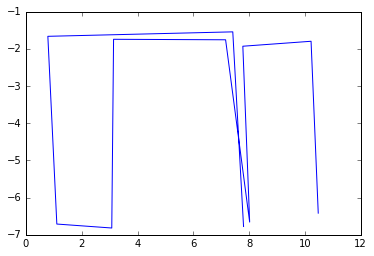

In [20]:
plt.plot(route_1_pos.X, -route_1_pos.Y)

In [21]:
filt_r_1 = filter_session(route_1_rssi)

In [22]:
filt_r_1.head()

,UUID,Major,Minor,RSSI,Timestamp
0,b9407f30f5f8466eaff925556b57fe6d,1,9616,-70.015146,1.493750e+12
4,b9407f30f5f8466eaff925556b57fe6d,1,9616,-69.945535,1.493750e+12
8,b9407f30f5f8466eaff925556b57fe6d,1,9616,-69.875445,1.493750e+12
13,b9407f30f5f8466eaff925556b57fe6d,1,9616,-69.807840,1.493750e+12
22,b9407f30f5f8466eaff925556b57fe6d,1,9616,-69.670250,1.493750e+12


In [23]:
from collections import defaultdict

In [24]:
class Bin:
    def __init__(self):
        self.x_values = []
        self.y_values = []
        self.rssi_values = defaultdict(list)
    
    def append_x(self, x):
        self.x_values.append(x)
    
    def append_y(self, y):
        self.y_values.append(y)
        
    def append_rssi(self, minor, rssi):
        self.rssi_values[minor].append(rssi)
    
    def calc_x(self):
        return np.mean(self.x_values)
    
    def calc_y(self):
        return np.mean(self.y_values)
    
    def calc_rssi(self):
        result = {}
        for k, v in self.rssi_values.items():
            result[k] = np.mean(v)
        return result
    
    def __str__(self):
        return "X: {}\nY: {}\nRSSI: {}".format(self.x_values, self.y_values, self.rssi_values)
        

In [25]:
def build_session_bins(sess_df, n_bins=100):
    sess_df = sess_df.copy()
    sess_df.Timestamp -= sess_df.Timestamp.min()
    bin_w = (sess_df.Timestamp.max()) / float(n_bins-1)
    result = [Bin() for _ in range(n_bins)]
    for _, row in sess_df.iterrows():
        i = int(row.Timestamp // bin_w)
        if 'X' in row and 'Y' in row:
            result[i].append_x(row.X)
            result[i].append_y(row.Y)
        result[i].append_rssi(row.Minor, row.RSSI)
    return result

In [26]:
def build_bins(rssi_df, bins_per_sess=100):
    bins = []
    for s in rssi_df.SessId.unique():
        bins += build_session_bins(rssi_df[rssi_df.SessId == s], bins_per_sess)
    return bins

In [27]:
train_bins = build_bins(filtered_df)

In [28]:
test_bins = build_session_bins(filt_r_1)

In [29]:
def eucledian_dist(bin1, bin2):
    r1 = bin1.calc_rssi()
    r2 = bin2.calc_rssi()
    keys = r1.keys() | r2.keys()
    dist = 0
    for k in keys:
        if not k in r1:
            r1[k] = -90
        if not k in r2:
            r2[k] = -90
        dist += (r1[k] - r2[k]) ** 2
    return np.sqrt(dist)

In [30]:
def find_closest(current, bin_list):
    closest = eucledian_dist(current, bin_list[0])
    closest_dist = 1000000000000
    for i in range(len(bin_list)):
        dist = eucledian_dist(current, bin_list[i])
        if dist < closest_dist:
            closest_dist = dist
            closest = i
    return bin_list[closest]

In [178]:
x = []
y = []
for b in test_bins:
    pos = find_closest(b, train_bins)
    x.append(pos.calc_x())
    y.append(pos.calc_y())

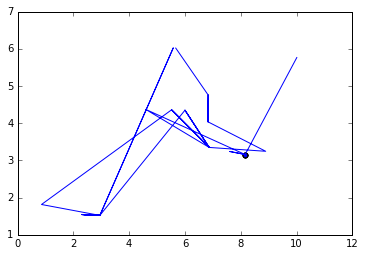

In [183]:
plt.plot(x, y)
plt.scatter(x[15:25], y[15:25])

In [184]:
class Locator:
    
    '''
    training_data - list of filtered data points ((x, y) {rssi_values...})
    '''
    def __init__(self, training_data, window_size=30):
        self.training_data = training_data
        self.current_window = []
        self.window_size = window_size
    
    def push_data(self, beacon_minor, rssi_value):
        self.current_window.append((beacon_minor, rssi_value))
        if len(self.current_window) > self.window_size:
            self.current_window = self.current_window[1:self.window_size + 1]
    
    def get_location(self):
        pass        
        
        
    
    

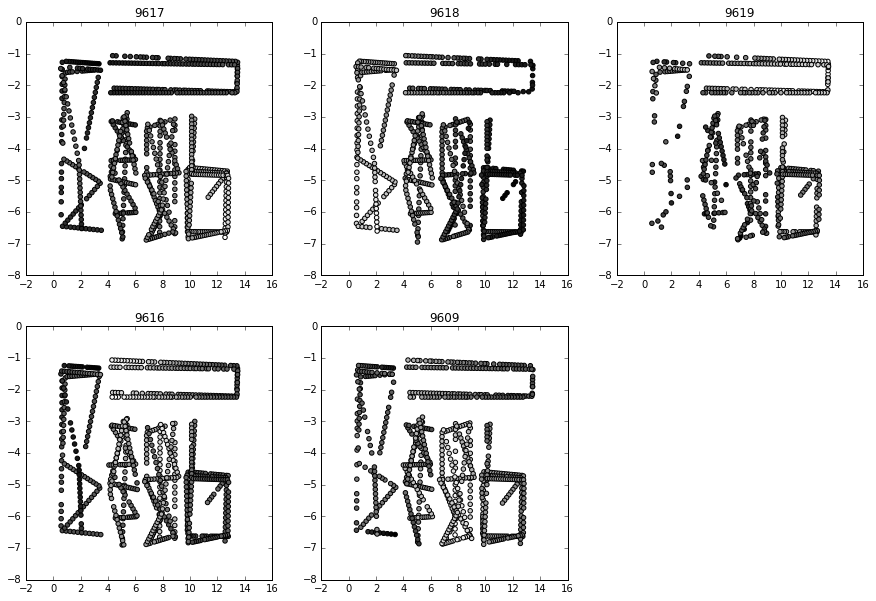

In [34]:
plot_rssi_map(filtered_df)

In [154]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.base import clone

In [155]:
from sklearn.ensemble import RandomForestRegressor

In [169]:
def build_regression_map(rssi_df, regressor, preprocessor=None, figsize=(15, 10)):
    unique_minors = rssi_df.Minor.unique()
    fig = plt.figure(figsize=figsize)
    for i, minor in enumerate(unique_minors):
        minor_df = rssi_df[rssi_df.Minor == minor]
        train_in = minor_df[['X','Y']].as_matrix()
        train_out = -minor_df[['RSSI']].as_matrix().ravel()
        if preprocessor:
            train_in = preprocessor.fit_transform(train_in)
        reg = clone(regressor)
        reg.fit(train_in, train_out)
        xy = np.mgrid[0:14:0.5, 0:-8:-0.5].reshape(2,-1).T
        test_in = np.mgrid[0:14:0.5, 0:-8:-0.5].reshape(2,-1).T
        if preprocessor:
            test_in = preprocessor.fit_transform(test_in)
        pred = reg.predict(test_in)
        ax = plt.subplot(int(np.ceil(len(unique_minors) / 3)), 3, 1 + i)
        ax.set_title(str(minor))
        plt.scatter(xy[:, 0], xy[:, 1], c=pred, cmap='Greys')


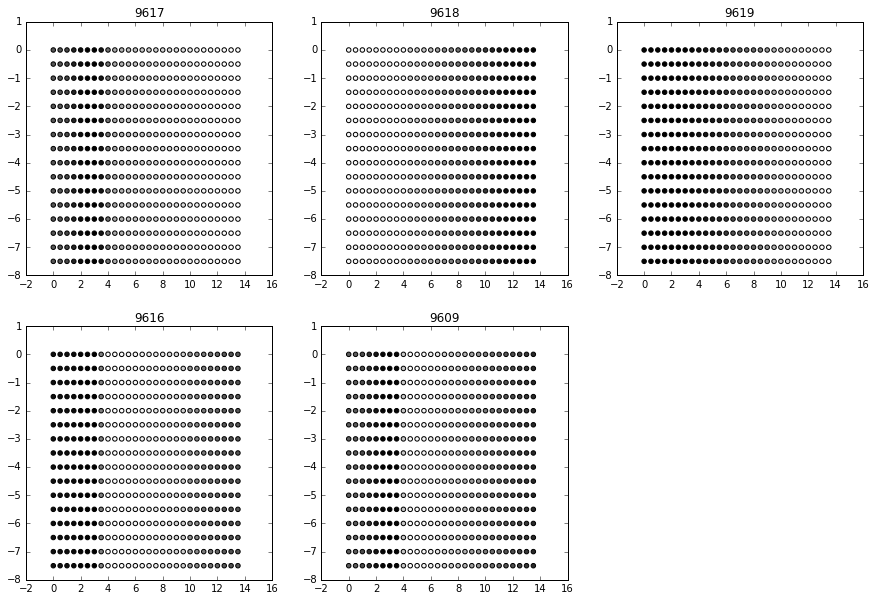

In [170]:
build_regression_map(filtered_df, RandomForestRegressor(n_estimators=100, max_depth=15))

In [171]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

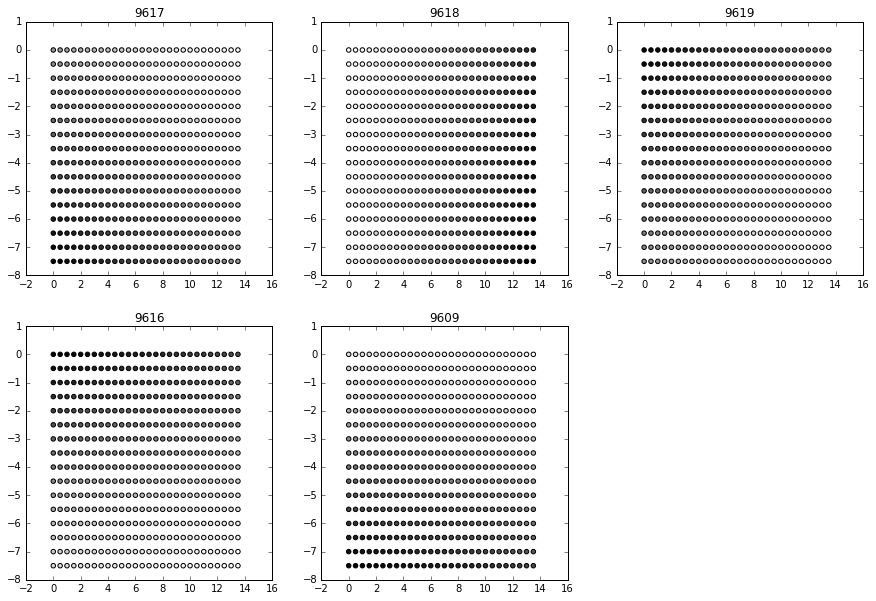

In [176]:
build_regression_map(filtered_df, LinearRegression())